In [1]:
from __future__ import division 
from fastai.vision import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from fastai.vision import *

In [2]:
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score, accuracy_score,roc_curve, auc
from sklearn.utils.fixes import signature
from itertools import cycle

Metrics for the multlabel classification

In [3]:
path = Path('All images/')

In [4]:
df = pd.read_csv('All images/label list.csv', sep=',')

In [7]:
np.where(df['Diseases']=='Emphysema')

(array([   26,   206,   219,   322, ..., 51280, 51444, 51485, 51631]),)

In [23]:
df.index[np.where(df['Diseases']=='Pneumothorax')]

Int64Index([    2,    44,    66,    90,   125,   150,   162,   168,   243,
              259,
            ...
            51525, 51537, 51542, 51571, 51657, 51679, 51687, 51701, 51718,
            51749],
           dtype='int64', length=2194)

In [29]:
df['Image names'][51525]

'00007497_013.png'

In [5]:
tfms = get_transforms(max_rotate=30, max_zoom=1.3, max_lighting=0.4, max_warp=0,
                     p_affine=1., p_lighting=1.)

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, label_delim='|', 
                               csv_labels='label list.csv', label_col=1, delimiter=',', valid_pct=0.2,
                              ds_tfms=tfms, bs=32, size=224, num_workers=3).normalize()

In [7]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta=1)

In [8]:
head_reg = nn.Sequential(Flatten(),
                        nn.Linear(50176,data.c))

In [9]:
learner = cnn_learner(data, models.densenet121, pretrained=False, metrics=[acc_02, f_score])

/home/felipe/anaconda3/envs/pytorch-env/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [11]:
learner.load('Dense-121-stage-1-MP-RandomCropZomm');

In [12]:
interp = ClassificationInterpretation.from_learner(learner)

In [13]:
ytrue = interp.y_true.cpu()
ypred = interp.pred_class.cpu()
probas = interp.probs.cpu()

In [14]:
np.repeat(ypred[1],14)

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [15]:
ytrue[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

calculate fpr and tpr for each class

In [16]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(data.valid_ds.c):
    fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.numpy().ravel(), probas.numpy().ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


calculate precision, recal and f1 for each class

In [17]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(data.valid_ds.c):
    precision[i], recall[i], _ = precision_recall_curve(ytrue[:, i],
                                                        probas[:, i])
    average_precision[i] = average_precision_score(ytrue[:, i], probas[:, i].round(),average='weighted')

In [18]:
ytrue.numpy().ravel()

array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32)

In [19]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(ytrue.numpy().ravel(),
    probas.numpy().ravel())
average_precision["micro"] = average_precision_score(ytrue, probas,
                                                     average="micro")

In [20]:
average_precision

{0: 0.3150342355865555,
 1: 0.23960264704692258,
 2: 0.09110230895565646,
 3: 0.0433774514539658,
 4: 0.46132932937680776,
 5: 0.07048347791411873,
 6: 0.030818278427205102,
 7: 0.005506714327118153,
 8: 0.46764631075004737,
 9: 0.1885267997078037,
 10: 0.12609488980140712,
 11: 0.06598396290213505,
 12: 0.03178436866003285,
 13: 0.19938241708012192,
 'micro': 0.47087652153254467}

In [21]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

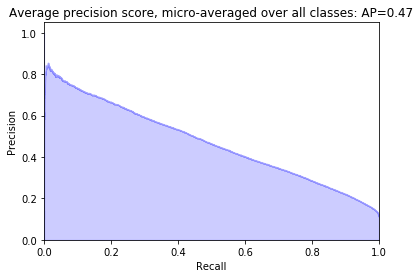

In [22]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.savefig('Average_precision_score.png')
plt.show()

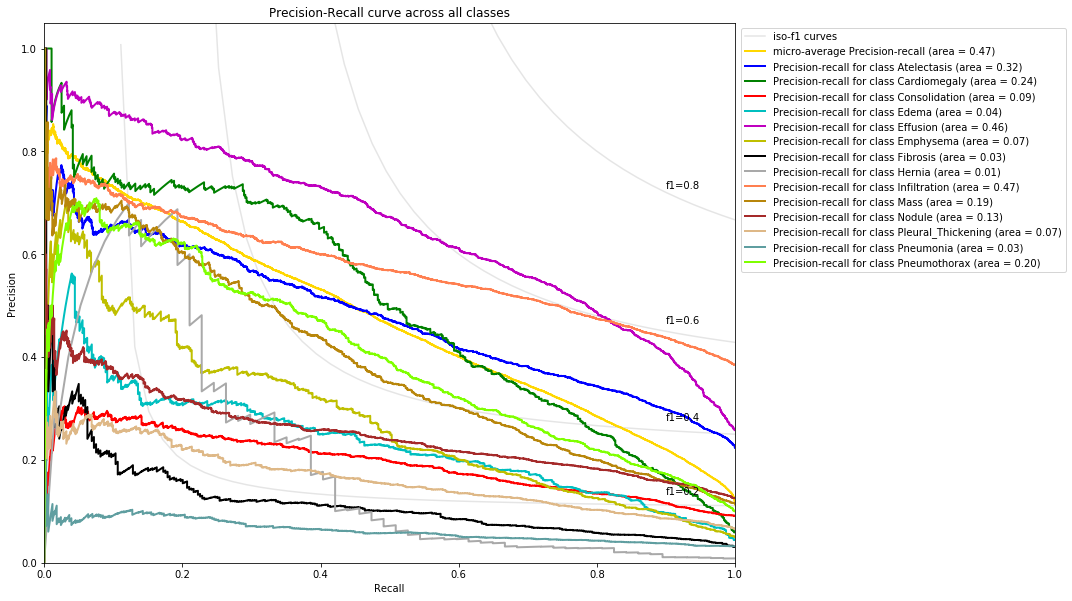

In [23]:
# setup plot details
colors = cycle(['b', 'g','r',
                'c','m','y',
                'k','darkgrey','coral', 
                'darkgoldenrod','brown','burlywood',
                'cadetblue','chartreuse'])

fig = plt.figure(figsize=[16,10])
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(data.valid_ds.c), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(data.classes[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve across all classes')
ax.legend(lines, labels,bbox_to_anchor=(1.001, 1), loc=2, prop=dict(size=10))
plt.savefig('PRC_for_all_classes.png')

plt.show()

In [24]:
for i in range(data.valid_ds.c):
    print('{0}:{1:0.2f}'.format(data.classes[i],average_precision[i]))

Atelectasis:0.32
Cardiomegaly:0.24
Consolidation:0.09
Edema:0.04
Effusion:0.46
Emphysema:0.07
Fibrosis:0.03
Hernia:0.01
Infiltration:0.47
Mass:0.19
Nodule:0.13
Pleural_Thickening:0.07
Pneumonia:0.03
Pneumothorax:0.20


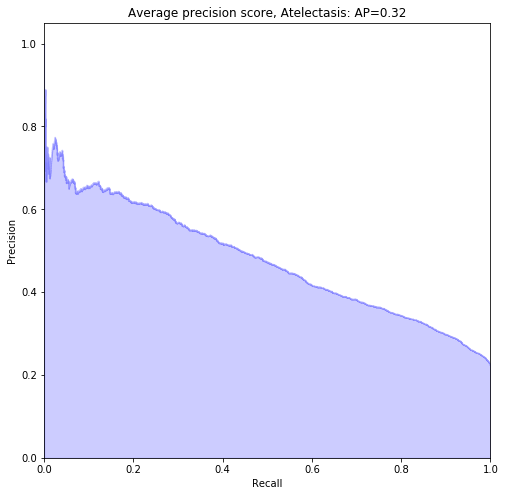

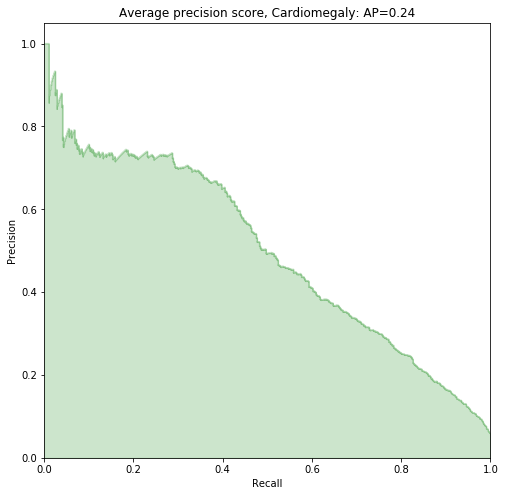

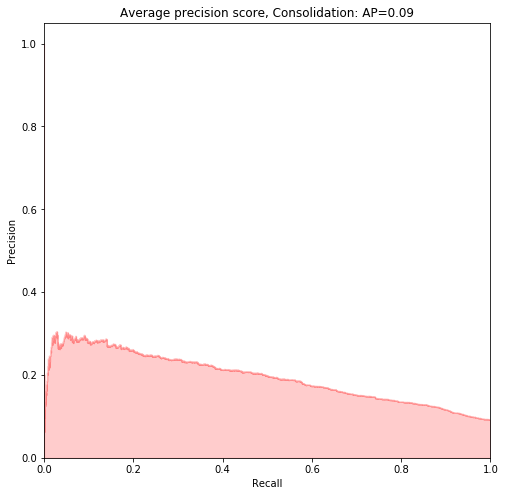

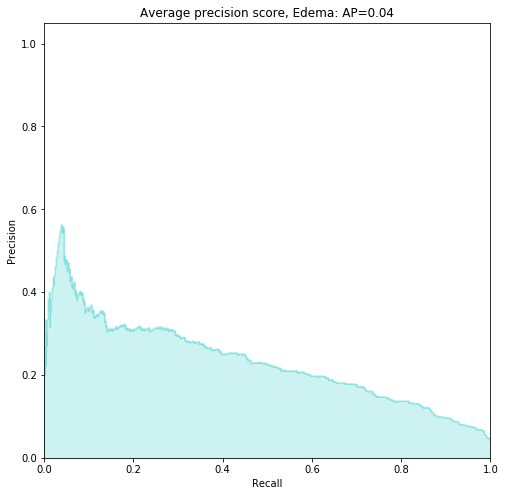

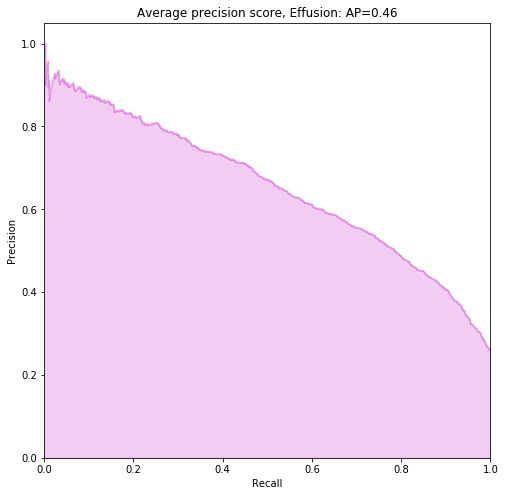

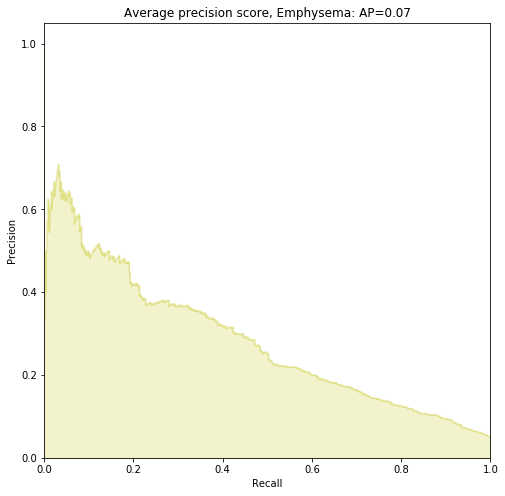

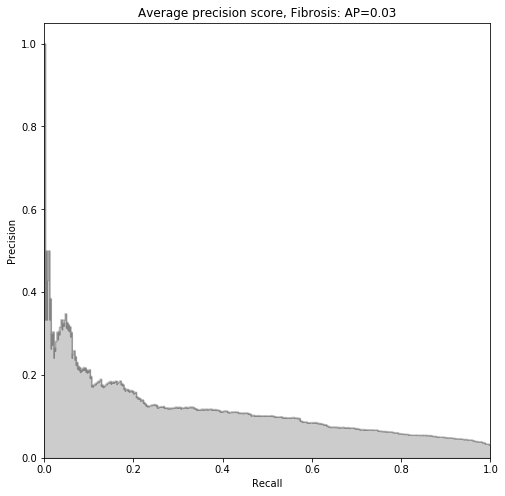

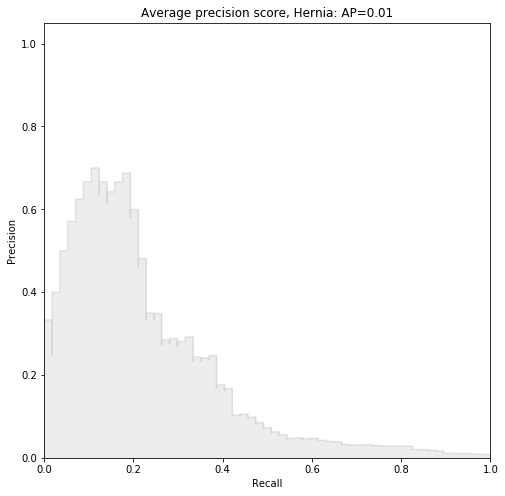

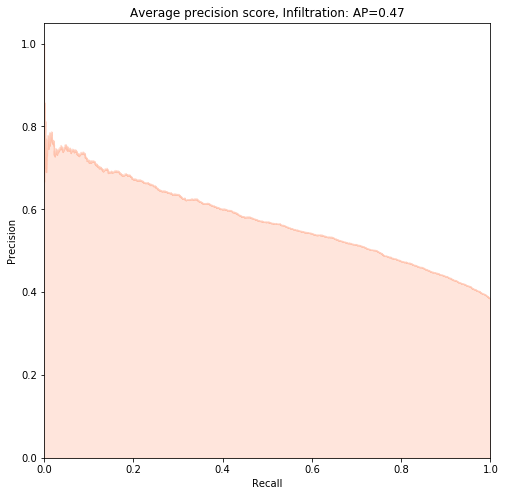

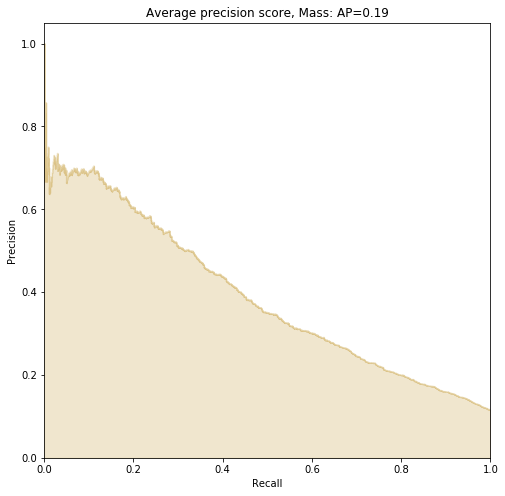

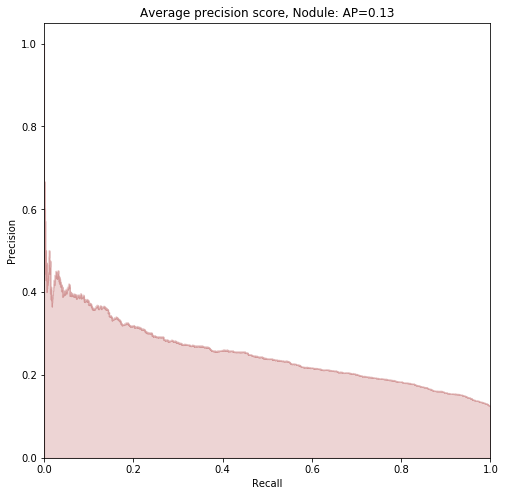

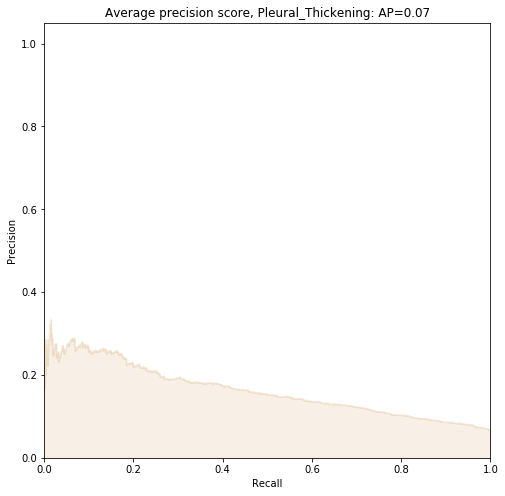

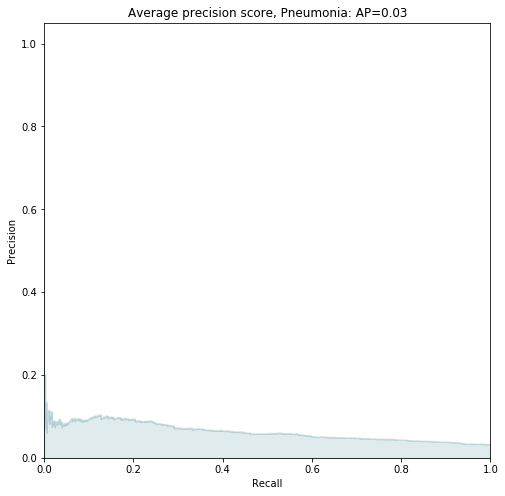

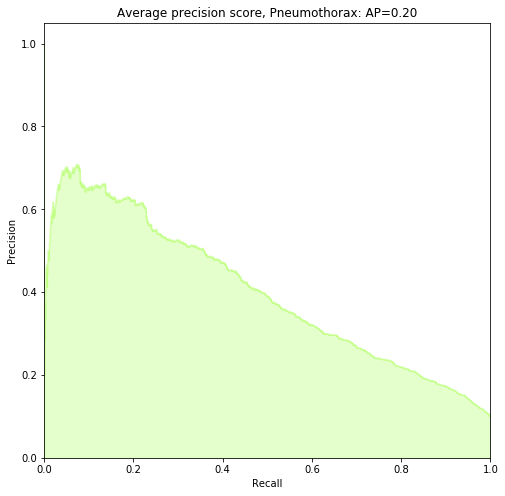

In [25]:
colors = cycle(['b', 'g','r',
                'c','m','y',
                'k','darkgrey','coral', 
                'darkgoldenrod','brown','burlywood',
                'cadetblue','chartreuse'])
for i, color in zip(range(data.valid_ds.c), colors):
    plt.figure(figsize=(8,8))
    plt.step(recall[i], precision[i], color=color, alpha=0.2,
             where='post')
    plt.fill_between(recall[i], precision[i], alpha=0.2, color=color,
                     **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, {0}: AP={1:0.2f}'
        .format(data.classes[i],average_precision[i]))
    plt.savefig('AP plots/Average_precision_score_{}.png'.format(data.classes[i]))

plot the avarage AUC

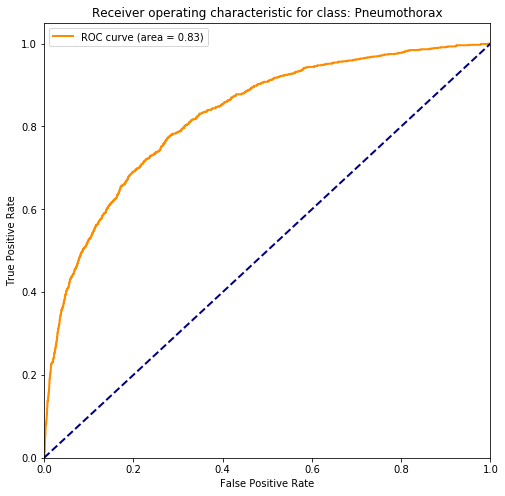

In [26]:
plt.figure(figsize=[8,8])
lw = 2
plt.plot(fpr[13], tpr[13], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[13])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for class: {}'.format(data.classes[13]))
plt.legend(loc="upper left")
plt.savefig('{}'.format(data.classes[13])+'_ROC_mult.png')
plt.show()

now the ROC for each class

In [27]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(data.valid_ds.c)]))

In [28]:
from scipy import interp as itpr
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(data.valid_ds.c):
    mean_tpr += itpr(all_fpr, fpr[i], tpr[i])

In [29]:
# Finally average it and compute AUC
mean_tpr /= data.valid_ds.c

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [30]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [31]:
list(colors.keys())[16:35]

['blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey']

In [32]:
cl_use = []
for i,k in enumerate(colors.items()):
    if i == 14:
        break
    cl_use.append(k[0])

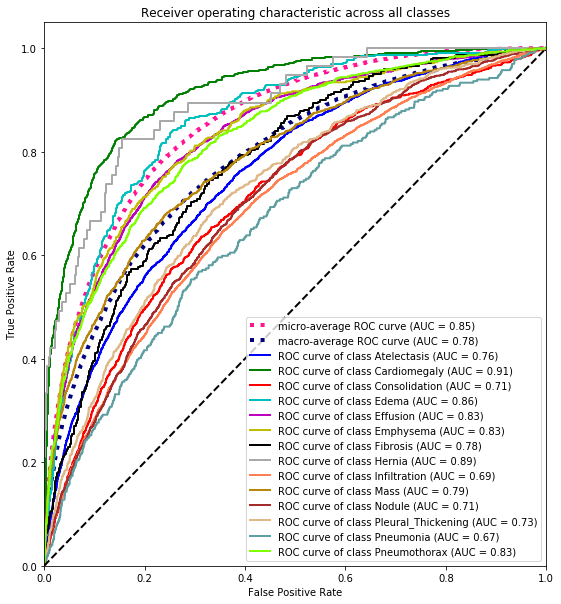

In [35]:
# Plot all ROC curves
plt.figure(figsize=[9,10])

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    
colors = cycle(['b', 'g','r',
                'c','m','y',
                'k','darkgrey','coral', 
                'darkgoldenrod','brown','burlywood',
                'cadetblue','chartreuse'])
for i, color in zip(range(data.valid_ds.c), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(data.classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic across all classes')
plt.legend(loc='best')
plt.savefig('ROC_for_all_classes.png')
plt.show()

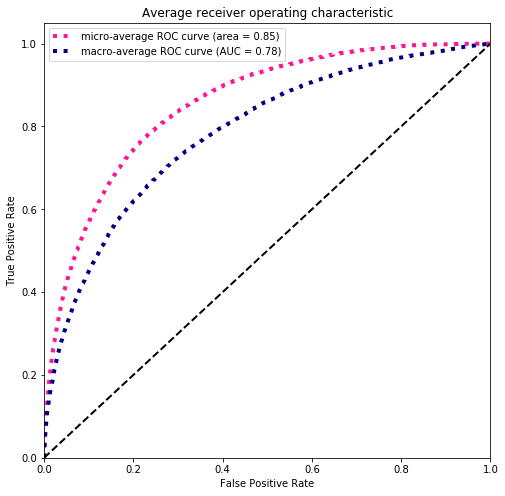

In [34]:
plt.figure(figsize=[8,8])
lw = 2

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average receiver operating characteristic')
plt.legend(loc="upper left")
plt.savefig('Avarage_ROC_mult.png')
plt.show()

In [ ]:
for i in range(data.valid_ds.c):
    print('{0}:{1:0.2f}'.format(data.classes[i],roc_auc[i]))

In [ ]:
for i in range(data.valid_ds.c):
    print('{0}:{1:0.2f}'.format(data.classes[i],average_precision[i]))

In [ ]:
print(learner.model[0][0][-3])

In [ ]:
m = learner.model.eval();

In [ ]:
list(data.valid_ds.y)[10327]

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y.raw[0]):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [ ]:
def show_heatmap(hm,tp='act'):
    fig, ax = plt.subplots(figsize=(8,8))
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
             interpolation='bilinear', cmap='jet',vmin=hm.min()*(1-0.25))
    ax.set_title('{}'.format(data.valid_ds.y[idx]))
    if tp == 'act':
        plt.savefig('act_map_plots/act_map_{}.png'.format(data.valid_ds.y[idx]))
    elif tp == 'grad':
        plt.savefig('grad_cam_plots/grad_map_{}.png'.format(data.valid_ds.y[idx]))

In [ ]:
data.classes[13]

In [ ]:
np.where(ytrue[:,13] == 1.)

In [ ]:
idx = 5
x,y = data.valid_ds[idx]
x.show(figsize=(8,8))
data.valid_ds.y[idx]

In [ ]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
xb_im.show(ax)
ax.set_title('{}'.format(data.valid_ds.y[idx]))
plt.savefig('original_{}.png'.format(data.valid_ds.y[idx]))

In [ ]:
hook_a, hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
show_heatmap(avg_acts)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult,tp='grad')

In [ ]:
acts.shape

In [ ]:
grad_chan.min()

In [ ]:
mult.min()